In [45]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import set_config; set_config(display='diagram')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Use this cell to regroup all your imports

from scipy import stats

# sklearn preproc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import make_scorer mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

# Load data

## Dataset just for test

In [ ]:
from sklearn import datasets

data = datasets.load_diabetes(return_X_y=False, as_frame=False)

In [ ]:
X = pd.DataFrame(data['data'])

In [ ]:
y = pd.Series(data['target'])

## Train data

In [ ]:
# Let's load our training dataset
data = pd.read_csv() #or xarray or erdap, etc
X = data.drop(columns='velocity')
y = data['velocity']

## Test data

In [ ]:
X_test = pd.read_csv() #or xarray or erdap, etc

# Prepare data

## Build pipeline for preproc data

This pipeline is important to adjust the data to enter in the DL model.

We are applying two corrections:
- KNNImputer: to impute value when we have missing data. It will get the closest value to complete
- Standardcale: to use ML and DL models, we have to rescale all variables to the same scale. I choose Standard sclae, but it will depends on the hist distribuition of the variations (normal distribution and outliers)

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>],
       [<AxesSubplot:title={'center':'9'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

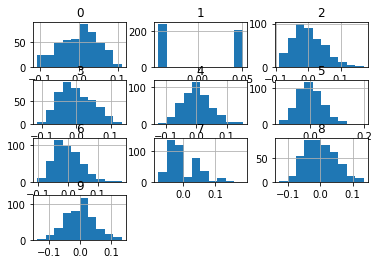

In [51]:
X.hist()

In [35]:
def create_preproc(X):
    preproc_numerical = make_pipeline(
        KNNImputer(),
        StandardScaler()
    )
    feat_numerical = sorted(X.select_dtypes(
        include=["int64", "float64"]).columns)
    
    feature_transformer = ColumnTransformer(
        [
        ("numerical_encoder", preproc_numerical, feat_numerical)
        ],
        remainder="drop")

    
    preproc = make_pipeline(
        feature_transformer,
    )

    return preproc


## Preproc data

Just to show the preproc model ⬇️

In [36]:
preproc = create_preproc(X)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_encoder',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                   9])]))])

Fit and transform the data ⬇️

In [37]:
preproc.fit(X)

# Machine Learning

In [ ]:
pipe_baseline = make_pipeline(preproc_baseline, Ridge())
pipe_baseline

In [ ]:
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring='mse').mean()
score_baseline

In [ ]:
pipe_baseline.fit(X,y)
y_pred_baseline = pipe_baseline.predict(X_test)
y_pred_baseline

# Deep Learning

## Preproc data

In [ ]:
X_preproc = preproc.transform(X)

## Create validation split

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X_preproc, y, test_size=0.3, random_state=0)

## Initialize model

See the shape of your data and try insert the number of columns in the input_dim value

In [39]:
X_preproc.shape

(442, 10)

In [40]:
input_dim = 10 #insert here the number of dimensions of the X data

In [41]:
def initialize_model(input_dim):

    model = models.Sequential()

    model.add(layers.Dense(20, activation='relu', input_dim=input_dim))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))

    model.add(layers.Dense(1, activation='linear')) 

    model.compile(optimizer='adam',
                  loss='msle')# optimize for the squared log error!
    
    return model

Initialize modal and show its summary

In [43]:
model = initialize_model(input_dim)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,081
Trainable params: 1,081
Non-trainable params: 0
_________________________________________________________________


## Fit model to your data

In [46]:
es = EarlyStopping(patience=30, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=100,
                    batch_size=16, 
                    verbose=1, 
                    callbacks=[es])

2021-08-04 19:25:45.044626: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-04 19:25:45.062143: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1190400000 Hz


Epoch 1/100
14/14 [==============================] - 0s 8ms/step - loss: 20.5365 - val_loss: 18.7059
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 17.7482 - val_loss: 16.0815
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 15.2825 - val_loss: 13.9094
Epoch 4/100
14/14 [==============================] - 0s 2ms/step - loss: 13.1897 - val_loss: 12.0139
Epoch 5/100
14/14 [==============================] - 0s 2ms/step - loss: 11.3717 - val_loss: 10.3558
Epoch 6/100
14/14 [==============================] - 0s 2ms/step - loss: 9.7832 - val_loss: 8.8775
Epoch 7/100
14/14 [==============================] - 0s 2ms/step - loss: 8.3906 - val_loss: 7.6219
Epoch 8/100
14/14 [==============================] - 0s 2ms/step - loss: 7.2179 - val_loss: 6.5609
Epoch 9/100
14/14 [==============================] - 0s 2ms/step - loss: 6.2264 - val_loss: 5.6816
Epoch 10/100
14/14 [==============================] - 0s 2ms/step - loss: 5.3983 - val_loss: 4.9399

Epoch 83/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2053 - val_loss: 0.1941
Epoch 84/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2041 - val_loss: 0.1925
Epoch 85/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2028 - val_loss: 0.1908
Epoch 86/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2016 - val_loss: 0.1891
Epoch 87/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2004 - val_loss: 0.1877
Epoch 88/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1993 - val_loss: 0.1859
Epoch 89/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1981 - val_loss: 0.1847
Epoch 90/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1970 - val_loss: 0.1831
Epoch 91/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1960 - val_loss: 0.1818
Epoch 92/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1948 - val_loss: 0.1801


## Evaluate the model

In [47]:
def plot_history(history):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('MSLE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()

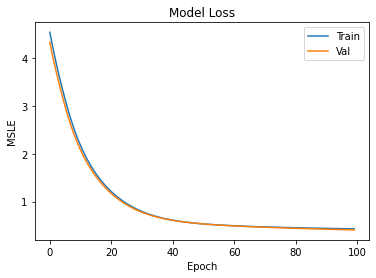

In [48]:
plot_history(history)

In [49]:
model.evaluate(X_val, y_val, verbose=0)

0.18283532559871674

## Predict the data

In [ ]:
y_pred = model.predict(preproc.transform(X_test))